# Assignment 3
## Training a neural named entity recognition (NER) tagger 

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/): 

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:  

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


As always, make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.
<br>
<br>  

---

<br>

All additional packages:

In [ ]:
# %pip install pandas --q
# %pip install numpy --q
# %pip install torch torchvision --q
# %pip install transformers --q
# %pip install seaborn --q
# %pip install sklearn --q
# %pip install requests --q
# %pip install scikit-learn --q
# %pip install matplotlib --q
# %pip install tqdm --q
# %pip install scipy --q

All imports:
(You may add/change)

In [2]:
# general
import os
import copy
import random
import warnings
from typing import List,Tuple
from collections import defaultdict


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report


set warnings filter to ignore:

In [3]:
# TODO
# set warnings filter to ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Set random SEEDs:

In [4]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


Set GPU:

In [5]:
# make sure you're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'
print(f'Using {DEVICE} device')
# DEVICE = 'cpu'

Using cuda device


## Task 1:
Write a function for reading the data from a single file (of the ones that are provided above).   
- The function recieves a filepath 
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. 
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [6]:
# GitHub
train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

# Google-Drive
# train_link = 'https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing'
# dev_link   = 'https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing'
# test_link  = 'https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing'

In [7]:


import requests
from typing import List, Tuple

def read_data(filepath: str) -> List[Tuple[List[str], List[str]]]:
    """
    Reads in data from a file in the CoNLL format and returns a list of tuples,
    where each tuple contains two lists. The first list contains the words in a
    sentence, and the second list contains the corresponding named entity tags
    for each word.
    
    Args:
    - filepath (str): The path to the file to read in. (github or google-drive)
    
    Returns:
    - A list of tuples, where each tuple contains two lists. The first list
      contains the words in a sentence, and the second list contains the
      corresponding named entity tags for each word.
    """
    data = []
    with requests.get(filepath) as f:
        sentence = []
        tags = []
        for line in f.text.splitlines():
            line = line.strip()
            if line:
                parts = line.split()
                sentence.append(parts[0])
                tags.append(parts[-1])
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
        if sentence:
            data.append((sentence, tags))
    return data

# get the data from GitHub
train = read_data(train_link)
dev = read_data(dev_link)
test = read_data(test_link)

print(f'Train: {len(train)} sentences')
print(f'Dev: {len(dev)} sentences')
print(f'Test: {len(test)} sentences')
print(f'Train words: {sum(len(sentence) for sentence, _ in train)}')
print(f'Dev words: {sum(len(sentence) for sentence, _ in dev)}')
print(f'Test words: {sum(len(sentence) for sentence, _ in test)}')



Train: 1750 sentences
Dev: 250 sentences
Test: 500 sentences
Train words: 28440
Dev words: 3943
Test words: 8243


In [8]:
# eda (exploratory data analysis)
train_data = train
dev_data = dev
test_data = test

# train
train_words = [word for sentence in train_data for word in sentence[0]]
train_tags = [tag for sentence in train_data for tag in sentence[1]]
train_tags_count = pd.Series(train_tags).value_counts()

# dev
dev_words = [word for sentence in dev_data for word in sentence[0]]
dev_tags = [tag for sentence in dev_data for tag in sentence[1]]

# test
test_words = [word for sentence in test_data for word in sentence[0]]
test_tags = [tag for sentence in test_data for tag in sentence[1]]

# all
all_words = train_words + dev_words + test_words
all_tags = train_tags + dev_tags + test_tags

# unique
unique_words = set(all_words)
unique_tags = set(all_tags)

print(f'Unique words: {len(unique_words)}')
print(f'Unique tags: {len(unique_tags)}')
print(f'Unique tags: {unique_tags}')
print("train data size: ", len(train_data))
print("dev data size: ", len(dev_data))
print("test data size: ", len(test_data))
print("number of words in train data: ", len(train_words))
print("number of words in dev data: ", len(dev_words))
print("number of words in test data: ", len(test_words))


Unique words: 8954
Unique tags: 7
Unique tags: {'O', 'I-ORG', 'B-PER', 'I-LOC', 'B-LOC', 'I-PER', 'B-ORG'}
train data size:  1750
dev data size:  250
test data size:  500
number of words in train data:  28440
number of words in dev data:  3943
number of words in test data:  8243


In [9]:
# print examples
print('Example:')
print('Sentence:', train_data[0][0])
print('Tags:', train_data[0][1])
print('Word:', train_words[0])
print('Tag:', train_tags[0])

Example:
Sentence: ['Portuguesa', '2', 'Parana', '0']
Tags: ['B-ORG', 'O', 'B-ORG', 'O']
Word: Portuguesa
Tag: B-ORG


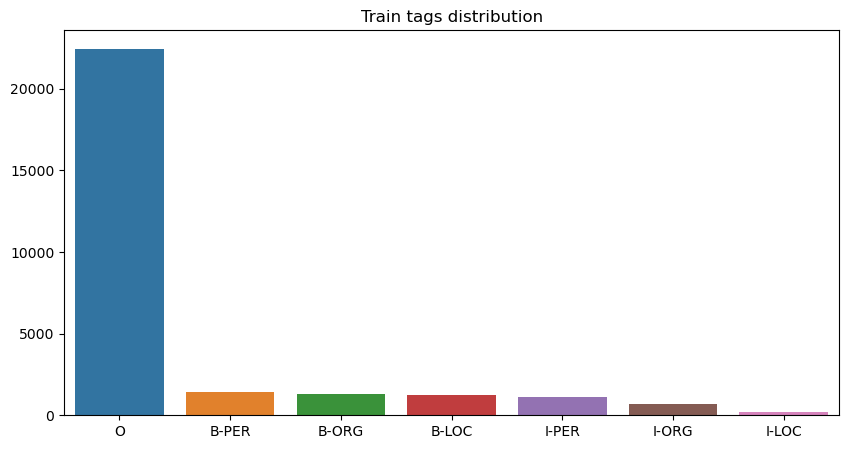

In [10]:
# plot tags
plt.figure(figsize=(10, 5))
sns.barplot(x=train_tags_count.index, y=train_tags_count.values)
plt.title('Train tags distribution')
plt.show()


<br><br><br><br><br><br>



## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.   
The UNK_TOKEN should be used for words that are not part of the training data.

Note: you may change the Vocab class

In [11]:
# To DO
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"

class Vocab:
    def __init__(self, train: List[Tuple[List[str], List[str]]]):
        # initialize word2id and id2word dictionaries with PAD_TOKEN and UNK_TOKEN
        self.word2id = {PAD_TOKEN: 0, UNK_TOKEN: 1}
        self.id2word = {0: PAD_TOKEN, 1: UNK_TOKEN}
        self.n_words = 2

        # initialize tag2id and id2tag dictionaries
        self.tag2id = {}
        self.id2tag = {}

        # initialize based on train dataset
        for sentence, tags in train:
            self.index_words(sentence)
            self.index_tags(tags)
        # add PAD_TOKEN to tag2id and id2tag dictionaries    
        # self.tag2id[PAD_TOKEN] = len(self.tag2id)
        # self.id2tag[len(self.id2tag)] = PAD_TOKEN
        

    def index_tags(self, tags: List[str]) -> List[int]:
        # convert tags to their corresponding ids
        tag_indexes = [self.index_tag(t) for t in tags]
        return tag_indexes

    def index_words(self, words: List[str]) -> List[int]:
        # convert words to their corresponding ids
        word_indexes = [self.index_word(w) for w in words]
        return word_indexes

    def index_word(self, w: str) -> int:
        # add new word to word2id and id2word dictionaries if it doesn't exist
        if w not in self.word2id:
            self.word2id[w] = self.n_words
            self.id2word[self.n_words] = w
            self.n_words += 1
        return self.word2id[w]

    def index_tag(self, t: str) -> int:
        # add new tag to tag2id and id2tag dictionaries if it doesn't exist
        if t not in self.tag2id:
            self.tag2id[t] = len(self.tag2id)
            self.id2tag[len(self.id2tag)] = t
        return self.tag2id[t]
    
    def convert_words_to_ids(self, words: List[str]) -> List[int]:
        # convert list of words to list of corresponding ids
        return [self.word2id.get(w, self.word2id[UNK_TOKEN]) for w in words]
    
    def convert_tags_to_ids(self, tags: List[str]) -> List[int]:
        # convert list of tags to list of corresponding ids
        return [self.tag2id[t] for t in tags]


# Testing - do not change
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()
del vcb


In [12]:
# print vocab details
vcb = Vocab(train)
print(f'Vocab size: {vcb.n_words}')
print(f'Tag size: {len(vcb.tag2id)}')
print(f'Word to id: {vcb.word2id}')
print(f'Tag to id: {vcb.tag2id}')


Vocab size: 7163
Tag size: 7
Word to id: {'<PAD>': 0, '<UNK>': 1, 'Portuguesa': 2, '2': 3, 'Parana': 4, '0': 5, 'At': 6, 'Trent': 7, 'Bridge': 8, ':': 9, 'Nottinghamshire': 10, '392-6': 11, '(': 12, 'G.': 13, 'Archer': 14, '143': 15, 'not': 16, 'PRESS': 17, 'DIGEST': 18, '-': 19, 'France': 20, 'Le': 21, 'Monde': 22, 'Aug': 23, '22': 24, '.': 25, 'England': 26, 'were': 27, 'all': 28, 'out': 29, 'for': 30, '326': 31, 'in': 32, 'their': 33, 'first': 34, 'innings': 35, 'on': 36, 'the': 37, 'second': 38, 'day': 39, 'of': 40, 'third': 41, 'and': 42, 'final': 43, 'test': 44, 'against': 45, 'Pakistan': 46, 'at': 47, 'The': 48, 'Oval': 49, 'Friday': 50, 'JORNAL': 51, 'DE': 52, 'ANGOLA': 53, 'Alaska': 54, 'Milk': 55, 'beat': 56, 'Purefoods': 57, 'Hotdogs': 58, '103-95': 59, '34-48': 60, 'half-time': 61, ')': 62, 'fighting': 63, 'has': 64, 'threatened': 65, 'a': 66, 'U.S.-led': 67, 'peace': 68, 'plan': 69, 'to': 70, 'unite': 71, 'mountainous': 72, 'Kurdish': 73, 'region': 74, 'northern': 75, 'Ira

Write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.  

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [13]:
def prepare_data(data, _vocab=None):
    data_sequences = []
    # initialize vocab if not provided
    if _vocab is None:
        _vocab = Vocab(data)
    # convert words and tags to ids
    data_sequences = [( _vocab.convert_words_to_ids(sentence), _vocab.convert_tags_to_ids(tags)) for sentence, tags in data]
    
    return data_sequences, _vocab

# sequences - list of tuples (word_indexes, tag_indexes)
train_sequences, vocab = prepare_data(train)
dev_sequences, _ = prepare_data(dev, vocab)
test_sequences, _ = prepare_data(test, vocab)

In [14]:
#print example
print('Example:')
print('Sentence:', train_data[0][0])
print('Tags:', train_data[0][1])
print('Word indexes:', train_sequences[0][0])
print('Tag indexes:', train_sequences[0][1])


Example:
Sentence: ['Portuguesa', '2', 'Parana', '0']
Tags: ['B-ORG', 'O', 'B-ORG', 'O']
Word indexes: [2, 3, 4, 5]
Tag indexes: [0, 1, 0, 1]


Print: how many OOV words are in the dev dataset? 

In [15]:
# print how many OOV words in the dev dataset, each OOV word was replaced with UNK_TOKEN
dev_words = [word for sentence in dev_sequences for word in sentence[0]]
dev_oov = [word for word in dev_words if word == vocab.word2id[UNK_TOKEN]]
dev_num_oov = len(dev_oov)
print('Number of OOV words in the dev dataset:', dev_num_oov)

Number of OOV words in the dev dataset: 638


Print: how many OOV words are in the test dataset? 

In [16]:
# print how many OOV words in the test dataset, each OOV word was replaced with UNK_TOKEN
test_words = [word for sentence in test_sequences for word in sentence[0]]
test_oov = [word for word in test_words if word == vocab.word2id[UNK_TOKEN]]
test_num_oov = len(test_oov)
print('Number of OOV words in the test dataset:', test_num_oov)

Number of OOV words in the test dataset: 1368


In [17]:
# TODO: Delete this cell before submitting, just a sanity check

# print how many OOV words in the train dataset, each OOV word was replaced with UNK_TOKEN
train_words = [word for sentence in train_sequences for word in sentence[0]]
train_oov = [word for word in train_words if word == vocab.word2id[UNK_TOKEN]]
train_num_oov = len(train_oov)
print('Number of OOV words in the train dataset:', train_num_oov)

Number of OOV words in the train dataset: 0


<br><br><br><br><br><br>

## Task 3:

Write NERNet, a PyTorch Module for labeling words with NER tags. 

> `input_size`: the size of the vocabulary  
`embedding_size`: the size of the embeddings  
`hidden_size`: the LSTM hidden size  
`output_size`: the number tags we are predicting for  
`n_layers`: the number of layers we want to use in LSTM  
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively  

<br>  

The input for your forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embedding. That means that you don't need to use pretrained embedding like the one used in class. You will use them in part 5.*

*Note: You may change the NERNet class.* 

In [18]:
# You may change the NERNet class.
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch import LongTensor

class NERNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers, dropout=0.0, bidirectional=False):
        super(NERNet, self).__init__()
        # TO DO: your code...
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size, padding_idx=vocab.word2id[PAD_TOKEN])
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout , bidirectional=bidirectional)
        self.out = nn.Linear(in_features=hidden_size * (2 if bidirectional else 1), out_features=output_size)
    
    def forward(self, input_sentence):
        # TO DO: your code...
        embeds = self.embedding(input_sentence)
        # get the lengths of each sequence in the batch
        lengths = (input_sentence != vocab.word2id[PAD_TOKEN]).sum(dim=1)

        # convert lengths cpu tensor to list (needed for pack_padded_sequence)
        lengths = lengths.tolist()
        # pack the padded sequences
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)

        lstm_out_packed, _ = self.lstm(packed_embeds)
        # unpack the padded sequences
        lstm_out, _ = pad_packed_sequence(lstm_out_packed, batch_first=True)
        tag_space = self.out(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=-1)
        return tag_scores

Create a Dataloader for the training phase

In [19]:
from torch.nn.utils.rnn import pad_sequence

# create a custom collate_fn function that converts sequences to tensors
def collate_fn_no_padding(batch):
  # convert batch of tuples to separate lists of tensors for words and tags
  words = [torch.tensor(seq[0]) for seq in batch]
  tags = [torch.tensor(seq[1]) for seq in batch]
  # pad the sequences
  words = pad_sequence(words, batch_first=True, padding_value=vocab.word2id[PAD_TOKEN])
  tags = pad_sequence(tags, batch_first=True, padding_value=len(vocab.tag2id))
  return words, tags

def prepare_data_loader(sequences, batch_size=64):
  # create a DataLoader with the custom collate_fn
  dataLoader = DataLoader(sequences, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_no_padding)
  return dataLoader

# create DataLoader objects for the training, validation, and testing sequences
dataLoader_train = prepare_data_loader(train_sequences, batch_size=64)
dataLoader_dev = prepare_data_loader(dev_sequences, batch_size=64)
dataLoader_test = prepare_data_loader(test_sequences, batch_size=64)

<br><br><br><br><br><br>

## Task 4:

Write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.  

The function will return the `loss` and `accuracy` durring training.  
(If you're using a different/additional metrics, return them too)

The loss is always CrossEntropyLoss and the optimizer is always Adam.
Make sure to use `tqdm` while iterating on `n_epochs`.


In [20]:
def train(model, criterion, optimizer, dataloader_train, pad_token_id):
  # set the model to training mode
  model.train()
  # initialize variables to track loss and accuracy
  train_loss = 0
  train_correct = 0
  train_total = 0
  # iterate over the training data
  for inputs, labels in dataloader_train:
    # convert inputs and labels to the appropriate device
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model.forward(inputs)
    # calculate the loss
    loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
    # backward pass
    loss.backward()
    # update the parameters
    optimizer.step()
    # calculate the training loss
    train_loss += loss.item()
    # calculate the training accuracy (ignoring PAD_TOKEN)
    train_correct += ((outputs.argmax(dim=-1) == labels) * (labels != pad_token_id)).sum().item()
    train_total += (labels != pad_token_id).sum().item()
  # calculate the average training loss and accuracy
  train_loss /= len(dataloader_train)
  train_accuracy = train_correct / train_total
  return train_loss, train_accuracy

In [21]:
def evaluate(model, criterion, dataloader_dev, pad_token_id):
  # set the model to evaluation mode
  model.eval()
  # initialize variables to track loss and accuracy
  dev_loss = 0
  dev_correct = 0
  dev_total = 0
  with torch.no_grad():
    # iterate over the dev data
    for inputs, labels in dataloader_dev:
      # convert inputs and labels to the appropriate device
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      # forward pass
      outputs = model(inputs)
      # calculate the loss
      loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
      # calculate the dev loss
      dev_loss += loss.item()
      # calculate the dev accuracy (ignoring PAD_TOKEN)
      dev_correct += ((outputs.argmax(dim=-1) == labels) * (labels != pad_token_id)).sum().item()
      dev_total += (labels != pad_token_id).sum().item()

  # calculate the average dev loss and accuracy
  dev_loss /= len(dataloader_dev)
  dev_accuracy = dev_correct / dev_total
  return dev_loss, dev_accuracy


In [22]:
def train_loop(model, n_epochs, dataloader_train, dataloader_dev, pad_token_id):
  # define the loss function and optimizer
  criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
  optimizer = Adam(model.parameters(), lr=0.0001)

  # initialize a dictionary to store the metrics
  metrics = {'loss': {'train': [], 'dev': []}, 'accuracy': {'train': [], 'dev': []}}

  # iterate over the specified number of epochs
  for epoch in tqdm(range(n_epochs)):
    train_loss, train_accuracy = train(model, criterion, optimizer, dataloader_train, pad_token_id)
    dev_loss, dev_accuracy = evaluate(model, criterion, dataloader_dev, pad_token_id)

    # store the metrics
    metrics['loss']['train'].append(train_loss)
    metrics['accuracy']['train'].append(train_accuracy)
    metrics['loss']['dev'].append(dev_loss)
    metrics['accuracy']['dev'].append(dev_accuracy)

  # return the metrics
  return metrics

In [23]:
# train the model
model = NERNet(input_size=len(vocab.word2id), embedding_size=300, hidden_size=512, output_size=len(vocab.tag2id), n_layers=2, dropout=0.5, bidirectional=True).to(DEVICE)
metrics = train_loop(model, n_epochs=20, dataloader_train=dataLoader_train, dataloader_dev=dataLoader_dev, pad_token_id=len(vocab.tag2id))

100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


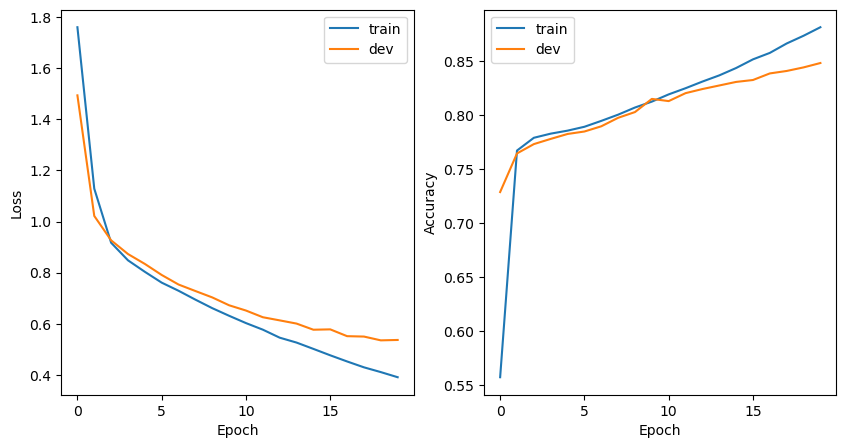

In [24]:
# plot the loss and accuracy curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metrics['loss']['train'], label='train')
plt.plot(metrics['loss']['dev'], label='dev')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(metrics['accuracy']['train'], label='train')
plt.plot(metrics['accuracy']['dev'], label='dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<br><br><br><br><br><br>

## Task 5:
Write an evaluation loop on a trained model, using the dev and test datasets.   
This function will print a `RECALL-PERCISION-F1` scores and plot a `confusion matrix`.  

Do this twice: once for all the labels (7 labels in total), and once for all the labels except O (6 labels in total).   





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic average
- *For all these metries use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

To display:
1. Print a `RECALL-PERCISION-F1` scores in a `tabulate` format (similar to assignment#2)
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.


In [26]:
# define a function to get the actual and predicted tags
def get_flattened_actuals_and_predictions(model, dataloader, vocab, pad_token=PAD_TOKEN):
    # set the model to evaluation mode
    model.eval()
    # initialize the actual and predicted tags
    actuals = []
    predictions = []
    with torch.no_grad():
        # loop over the data in the dataloader
        for inputs, labels in dataloader:
            # move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # get the model outputs and predicted tags
            outputs = model.forward(inputs)
            outputs = outputs.argmax(dim=-1)

            # loop over the sequences in the batch
            for i in range(inputs.size(0)):
                # get the sequence and its corresponding outputs and labels
                seq = inputs[i]
                try:
                    pad_start_idx = (seq == vocab.word2id[pad_token]).nonzero(as_tuple=True)[0][0]
                except IndexError:  # if no padding token is found
                    pad_start_idx = len(seq)

                seq_outputs = outputs[i, :pad_start_idx]
                seq_labels = labels[i, :pad_start_idx]

                # convert the predicted and actual tags to their corresponding strings
                predicted_tags = [vocab.id2tag[tag.item()] for tag in seq_outputs]
                actual_tags = [vocab.id2tag[tag.item()] for tag in seq_labels]

                # add the predicted and actual tags to the lists
                actuals.extend(actual_tags)
                predictions.extend(predicted_tags)

    # return the actual and predicted tags
    return actuals, predictions

# define a function to remove 'O' tags from the actual and predicted tags
def remove_O_tags(actuals, predictions):
    # get all positions of 'O' in actuals
    actuals_O_idx = [i for i, tag in enumerate(actuals) if tag == 'O']
    # remove actuals_O_idx from actuals and predictions
    actuals_without_O = [tag for i, tag in enumerate(actuals) if i not in actuals_O_idx]
    predictions_without_O = [tag for i, tag in enumerate(predictions) if i not in actuals_O_idx]
    # return the actual and predicted tags without 'O' tags
    return actuals_without_O, predictions_without_O

In [27]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# define a function to evaluate the model and print the evaluation metrics
def evaluate_and_print(model, title, dataloader, vocab, pad_token=PAD_TOKEN):
    # print the title of the evaluation
    print(title)

    # evaluate the model and get the evaluation metrics
    precision, recall, score, precision_without_O, recall_without_O, score_without_O, cm, cm_without_O = evaluate_model(model, dataloader, vocab, pad_token)

    # print the overall evaluation metrics
    print('Overall evaluation:')
    print(tabulate([['Precision', precision], ['Recall', recall], ['F1 Score', score]], headers=['Metric', 'Score']))
    plot_confusion_matrix(cm, list(vocab.tag2id.keys()), title)

    # print the evaluation metrics excluding 'O' tags
    print('Evaluation without O tags:')
    print(tabulate([['Precision', precision_without_O], ['Recall', recall_without_O], ['F1 Score', score_without_O]], headers=['Metric', 'Score']))
    plot_confusion_matrix(cm_without_O, list(vocab.tag2id.keys()), title + ' (excluding O tags)')
    print('\n')

# define a function to evaluate the model
def evaluate_model(model, dataloader, vocab, pad_token=PAD_TOKEN):
    # get the actual and predicted tags
    actuals, predictions = get_flattened_actuals_and_predictions(model, dataloader, vocab)

    # calculate the precision, recall, and f1 scores
    precision, recall, score = precision_recall_fscore_support(actuals, predictions, labels=list(vocab.tag2id.keys()), average='weighted')[:3]

    # calculate the precision, recall, and f1 scores (excluding 'O' tags)
    actuals_without_O, predictions_without_O = remove_O_tags(actuals, predictions)
    precision_without_O, recall_without_O, score_without_O = precision_recall_fscore_support(actuals_without_O, predictions_without_O, labels=list(vocab.tag2id.keys()), average='weighted')[:3]

    # calculate the confusion matrix
    cm = confusion_matrix(actuals, predictions, labels=list(vocab.tag2id.keys()))
    cm_without_O = confusion_matrix(actuals_without_O, predictions_without_O, labels=list(vocab.tag2id.keys()))

    # return the evaluation metrics
    return precision, recall, score, precision_without_O, recall_without_O, score_without_O, cm, cm_without_O

# define a function to plot the confusion matrix
def plot_confusion_matrix(cm, labels, title):
    # transpose the confusion matrix (predicted as rows, actual as columns)
    cm = cm.T
    # plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()


Train
Overall evaluation:
Metric        Score
---------  --------
Precision  0.874619
Recall     0.884564
F1 Score   0.869321


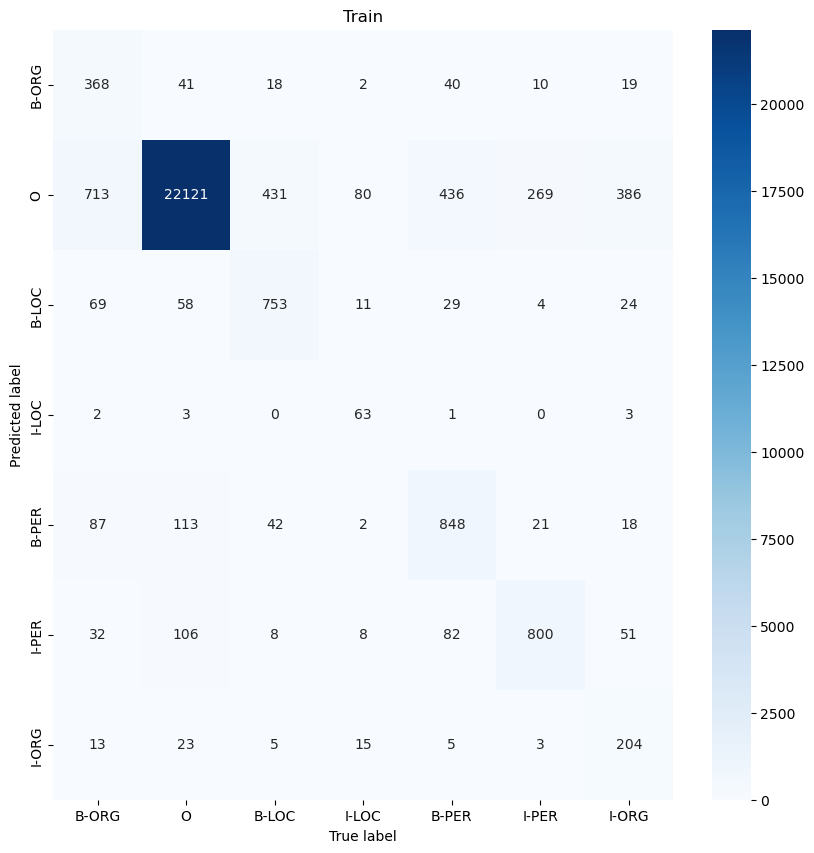

Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.828928
Recall     0.508117
F1 Score   0.612665


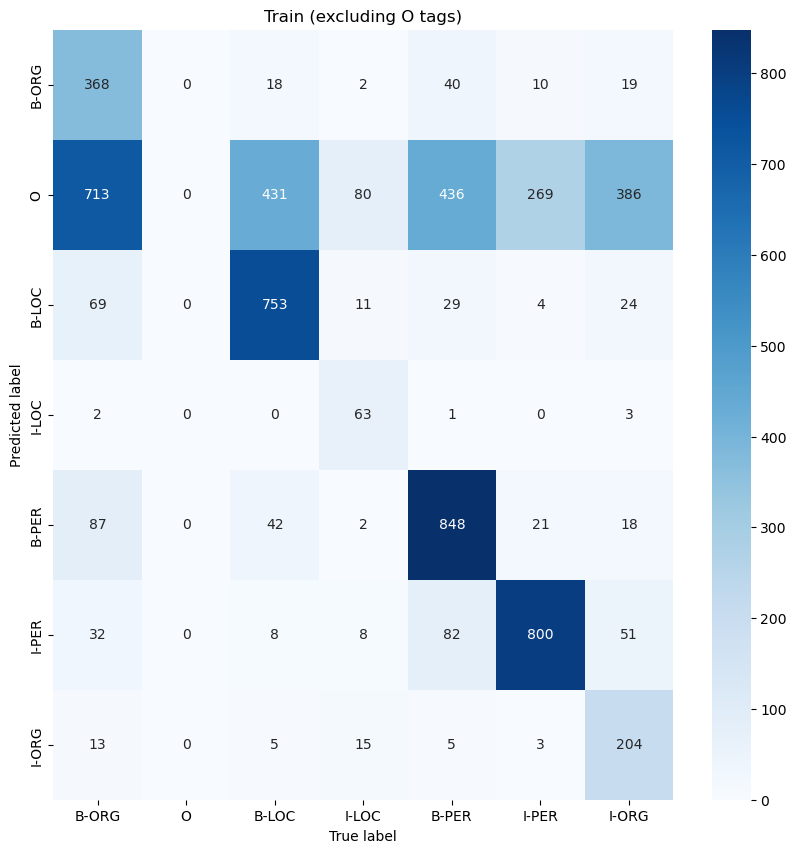



Dev
Overall evaluation:
Metric        Score
---------  --------
Precision  0.825651
Recall     0.848085
F1 Score   0.82575


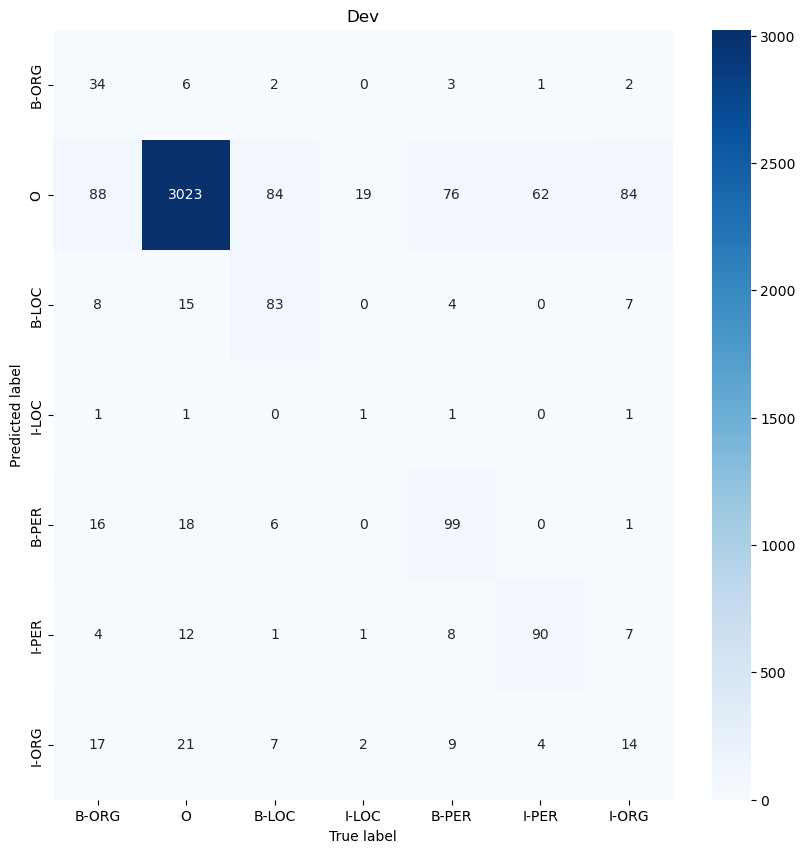

Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.721246
Recall     0.378985
F1 Score   0.484464


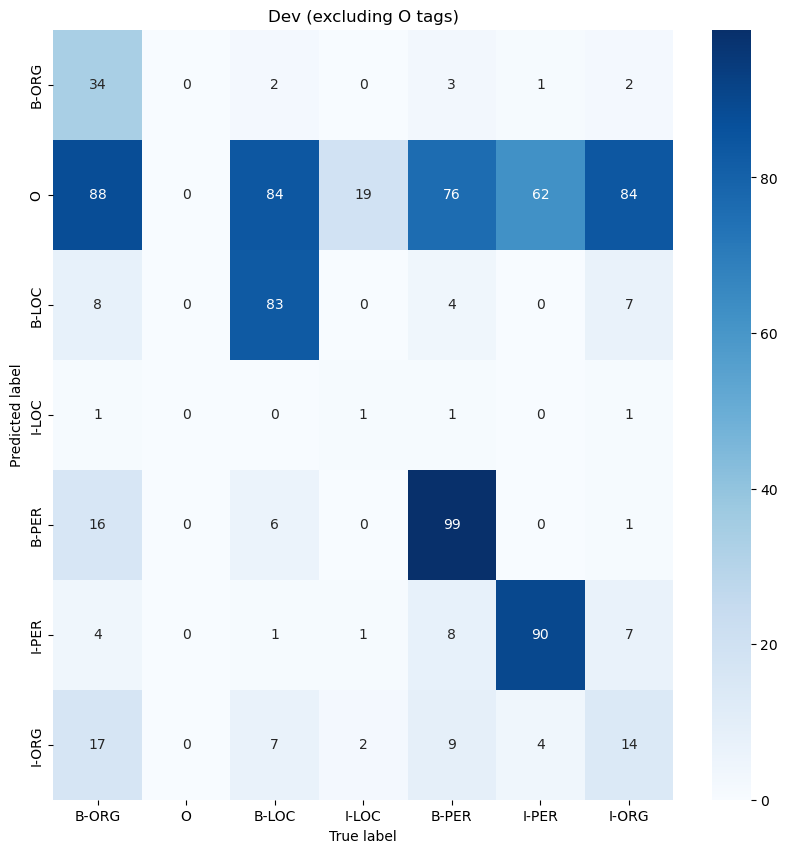



Test
Overall evaluation:
Metric        Score
---------  --------
Precision  0.834157
Recall     0.851025
F1 Score   0.832905


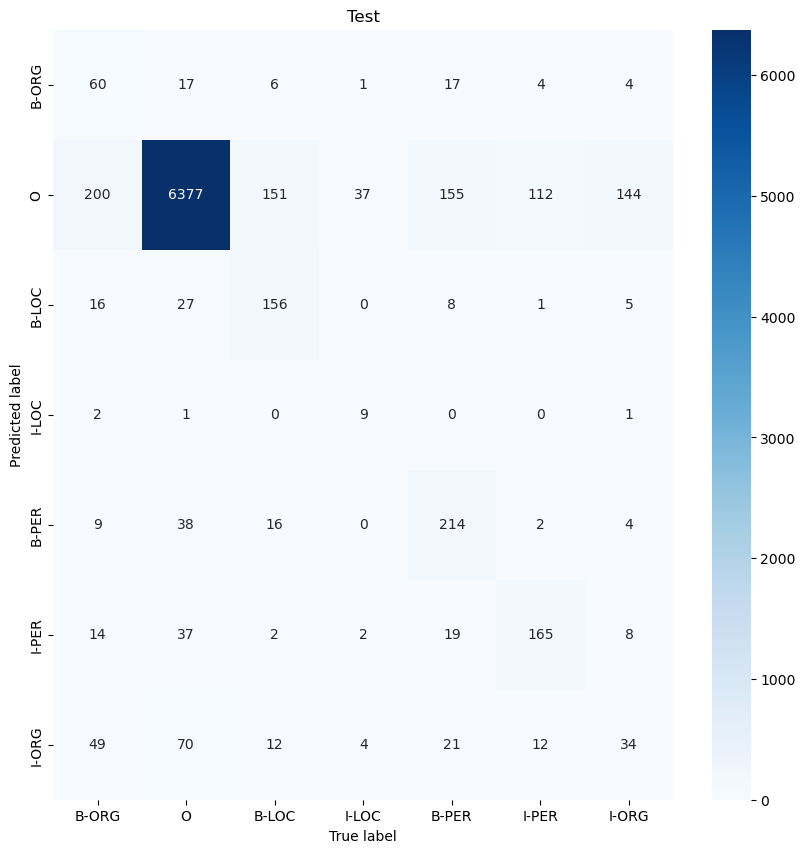

Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.727244
Recall     0.380668
F1 Score   0.489005


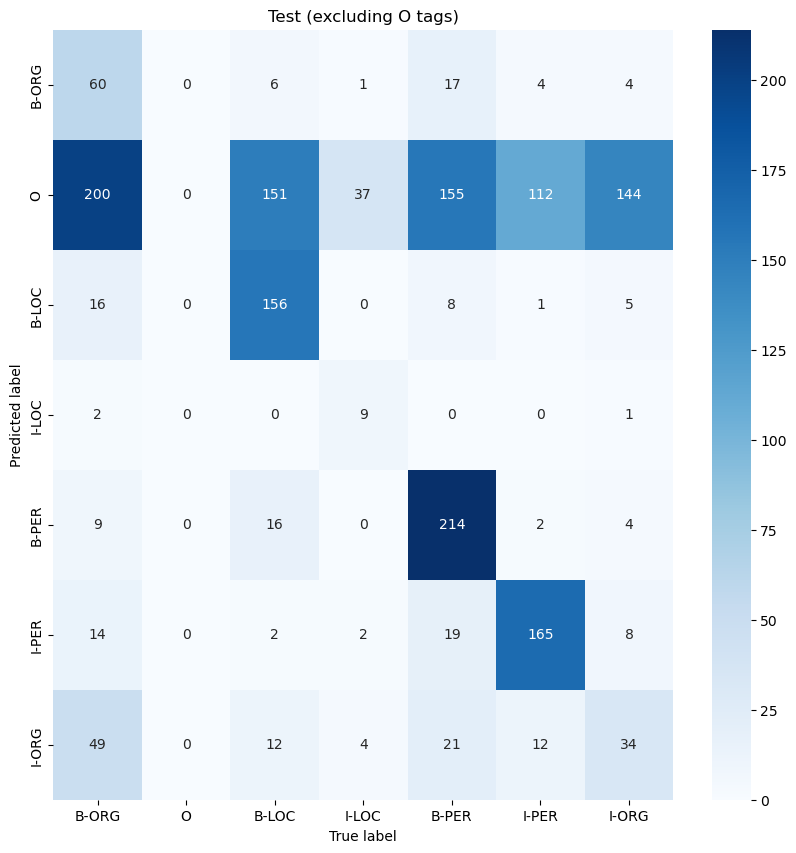

In [28]:
evaluate_and_print(model, 'Train', dataLoader_train, vocab, pad_token=PAD_TOKEN)

evaluate_and_print(model, 'Dev', dataLoader_dev, vocab, pad_token=PAD_TOKEN)

evaluate_and_print(model, 'Test', dataLoader_test, vocab, pad_token=PAD_TOKEN)
    

<br><br><br><br><br><br>

## Task 6:

Reset all seeds to 42.

In [29]:
SEED = 42

# TO DO
# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters (you may use that as captions for the models as well):

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




In [30]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
models = {
    'Model1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

# train and evaluate the models, returning the results in a dataframe
def train_and_evaluate_models(models, vocab, dataLoader_train, dataLoader_dev, dataLoader_test, pad_token):   
    # Create an empty dictionary to store the results for each model
    results_dev = {}
    results_test = {}

    # Loop through each model in the dictionary
    for model_name, model_params in models.items():
        print(f'Training {model_name}')

        # Create the model
        model = NERNet(input_size=len(vocab.word2id), embedding_size=model_params['embedding_size'], hidden_size=model_params['hidden_size'], output_size=len(vocab.tag2id), n_layers=model_params['n_layers'], bidirectional=model_params['directions'] == 2)
        model.to(DEVICE)

        # Train the model
        metrics = train_loop(model, n_epochs=10, dataloader_train=dataLoader_train, dataloader_dev=dataLoader_dev, pad_token_id=len(vocab.tag2id))

        # Evaluate the model (dev set)
        precision_dev, recall_dev, f1_score_dev, precision_without_O_dev, recall_without_O_dev, f1_score_without_O_dev, cm_dev, cm_without_O_dev = evaluate_model(model, dataLoader_dev, vocab, pad_token=pad_token)

        # Evaluate the model (test set)
        precision_test, recall_test, f1_score_test, precision_without_O_test, recall_without_O_test, f1_score_without_O_test, cm_test, cm_without_O_test = evaluate_model(model, dataLoader_test, vocab, pad_token=pad_token)

        # Store the results for this model in the dictionary
        results_dev[model_name] = {
            'N_MODEL': model_name,
            'HIDDEN_SIZE': model_params['hidden_size'],
            'N_LAYERS': model_params['n_layers'],
            'DIRECTIONS': model_params['directions'],
            'RECALL': recall_dev,
            'PERCISION': precision_dev,
            'F1': f1_score_dev,
            'RECALL_WO_O': recall_without_O_dev,
            'PERCISION_WO_O': precision_without_O_dev,
            'F1_WO_O': f1_score_without_O_dev
        }

        # Store the results for this model in the dictionary
        results_test[model_name] = {
            'N_MODEL': model_name,
            'HIDDEN_SIZE': model_params['hidden_size'],
            'N_LAYERS': model_params['n_layers'],
            'DIRECTIONS': model_params['directions'],
            'RECALL': recall_test,
            'PERCISION': precision_test,
            'F1': f1_score_test,
            'RECALL_WO_O': recall_without_O_test,
            'PERCISION_WO_O': precision_without_O_test,
            'F1_WO_O': f1_score_without_O_test

        }

    # Convert the results dictionary to a pandas DataFrame
    results_df_dev = pd.DataFrame.from_dict(results_dev, orient='index')
    results_df_test = pd.DataFrame.from_dict(results_test, orient='index')

    # Return the results DataFrame
    return results_df_dev, results_df_test


In [31]:
results_df_dev, results_df_test = train_and_evaluate_models(models, vocab, dataLoader_train, dataLoader_dev, dataLoader_test, pad_token=PAD_TOKEN)

Training Model1


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Training Model2


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Training Model3


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Training Model4


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Training Model5


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Training Model6


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Training Model7


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Training Model8


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Training Model9


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


In [45]:
# print the results for the dev set in a table
print("Dev set")
print(tabulate(tabular_data=results_df_dev.values, headers=results_df_dev.columns.tolist(), tablefmt='github', showindex=False), end='\n\n')

# print the results for the test set in a table
print("Test set")
print(tabulate(tabular_data=results_df_test.values, headers=results_df_test.columns.tolist(), tablefmt='github', showindex=False))

Dev set
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------|---------------|------------|--------------|----------|-------------|----------|---------------|------------------|-----------|
| Model1    |           500 |          1 |            1 | 0.807507 |    0.761099 | 0.746854 |      0.135773 |         0.65689  |  0.213092 |
| Model2    |           500 |          2 |            1 | 0.806493 |    0.73152  | 0.742381 |      0.126328 |         0.494249 |  0.192834 |
| Model3    |           500 |          3 |            1 | 0.801167 |    0.708506 | 0.731095 |      0.094451 |         0.40831  |  0.148716 |
| Model4    |           500 |          1 |            2 | 0.835912 |    0.792604 | 0.793463 |      0.263282 |         0.649427 |  0.365706 |
| Model5    |           500 |          2 |            2 | 0.817652 |    0.824527 | 0.820524 |      0.488784 |         0.661506 |  0.56208  |
| Mod

**Save CSV**  
In addition, for each model use the `test` dataset and check the model metrics. 

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries use **weighted** ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

> - Save the results in a CSV
`{student_id_1}_{student_id_n}_part6.csv`    
For example: `300123123_200456789_part_6.csv`

> - Print the results as follows:  (results here are random)

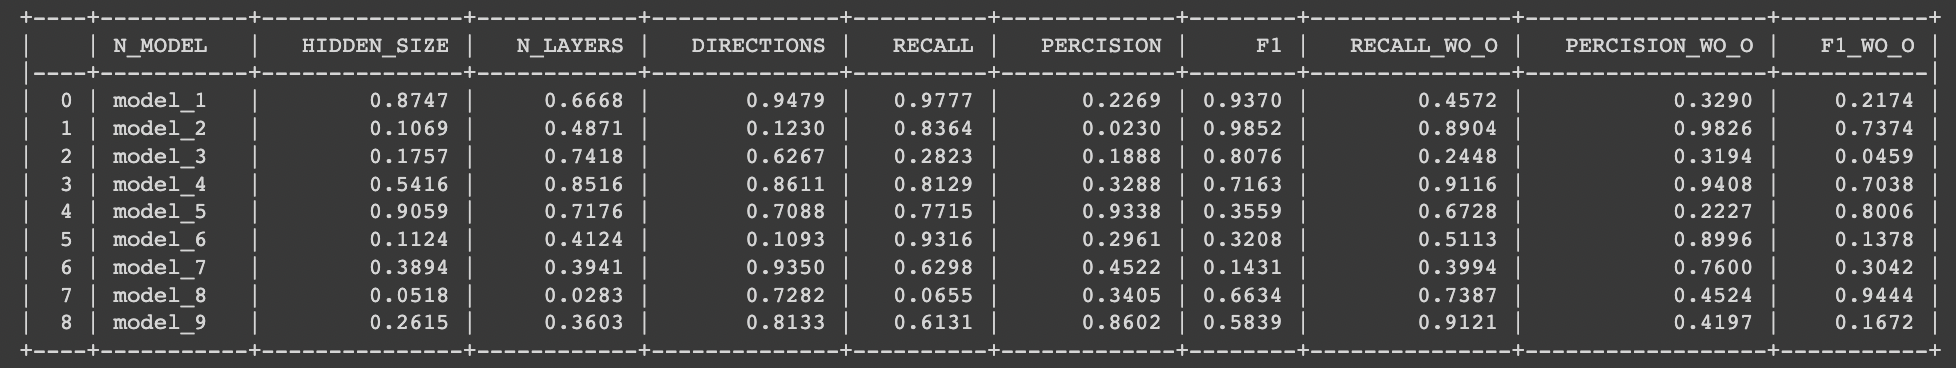

In [33]:
# for each model use the test set to evaluate the model

In [34]:
# Example:
# results_acc = np.random.rand(9, 10)
# df = pd.DataFrame(results_acc,columns=['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O'])
# df.N_MODEL = [f'model_{n}' for n in range(1,10)]
# print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

<br><br><br><br><br>

## Task 7: 

Reset all seeds to 42.

In [35]:
SEED = 42

# TO DO
# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


In preparation for this task you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: make sure that vectors are aligned with the IDs in your Vocab, in other words, make sure that for example the word with ID 0 is the first vector in the GloVe matrix of vectors that you initialize nn.Embedding with.*

---


Download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip). 


In [36]:
# TO DO

# download the pretrained word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip


Then intialize the `nn.Embedding` module in your `NERNet` with these embeddings, so that you can start your training with pre-trained vectors. 

In [37]:
# TO DO

Repeat `Task 6`

In [38]:
# TO DO

Same as `Task 6`, please display:

1. Print a `classification_report` in a tabulate format.
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.

In [39]:
# TO DO

- Save the results in a CSV {student_id_1}_{student_id_n}_part7.csv  
For example: 300123123_200456789_part_7.csv

- Print the results as follows:

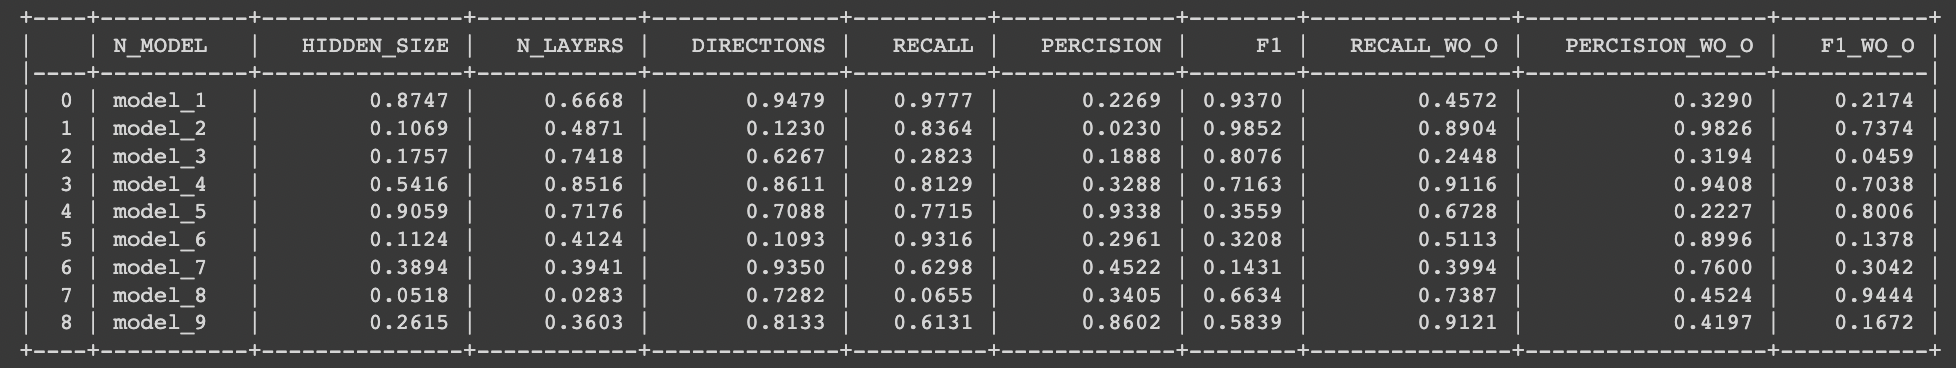

In [40]:
# TO DO

<br><br><br><br><br><br>
**Good luck!**